# Phrases

Process the phrases that appear in a relation.

## 1. Preprocess data

In [1]:
import copy
import json
import pandas as pd
import re

In [2]:
def read_data(file_name):
    json_data = []
    infile = open(file_name, "r")
    for line in infile:
        json_data.append(json.loads(line))
    infile.close()
    
    return json_data

In [3]:
def combine_data(json_data):
    combined_data = {}
    for data in json_data:
        key = f"{data['source_id']} {data['speech_id']} {data['paragraph_id']}"
        if key not in combined_data:
            combined_data[key] = copy.deepcopy(data)
        else:
            if len(data["data"]) != len(combined_data[key]["data"]):
                print("cannot happen")
            for label_data in data["label"]:
                if label_data not in combined_data[key]["label"]:
                    combined_data[key]["label"].append(label_data)
                    if combined_data[key]["label"][-1][1] > len(combined_data[key]["data"]):
                        combined_data[key]["label"][-1][1] = len(combined_data[key]["data"])
    for key in combined_data:
        for label_data in combined_data[key]["label"]:
            label_data.append(combined_data[key]["data"][label_data[0]:label_data[1]])
    return combined_data

In [4]:
def tokenize(combined_data):
    for data_key in combined_data:
        paragraph = combined_data[data_key]["data"]
        tokens = {}
        token_id = -1
        for i in range(0, len(paragraph)):
            if token_id < 0 and paragraph[i] == " ":
                next
            elif token_id < 0:
                token_id = i
                tokens[token_id] = paragraph[i]
            elif paragraph[i] == " ":
                token_id = -1
            elif re.search("[.,?!]", paragraph[i]):
                tokens[i] = paragraph[i]
            else:
                tokens[token_id] += paragraph[i]
        labels = {}
        for label_key in tokens:
            labels[label_key] = "O"
        for label in combined_data[data_key]["label"]:
            if label[2] == 'Content_Concept_1' or label[2] == 'Content_Concept_2':
                for label_key in labels:
                    if label_key >= label[0] and label_key < label[1]:
                        labels[label_key] = "C"
            elif label[2] == 'Content_Relation_Explanation':
                for label_key in labels:
                    if label_key >= label[0] and label_key < label[1]:
                        labels[label_key] = "E"
        combined_data[data_key]["tokens"] = [ (tokens[label_key], labels[label_key]) for label_key in labels ]
    return combined_data

In [5]:
json_data = read_data("../data/femke.jsonl")
combined_data = combine_data(json_data)
combined_data = tokenize(combined_data)

## 2. Visualize data

In [37]:
def make_ids(labels, text):
    ids = {}
    for label_data in labels:
        while text[label_data[0]] in " .,?!:;":
            label_data[0] += 1
        while text[label_data[1]-1] in " .,?!:;":
            label_data[1] -= 1
        if label_data[0] in ids or label_data[1] in ids:
            print(f"overlapping relation parts! {data_item['label']}")
        ids[label_data[0]] = { "type": "start", "label": label_data[2] }
        ids[label_data[1]] = { "type":"end", "label": label_data[2] }
    return ids 

In [40]:
def add_colors_to_text(text, ids):
    for key in sorted(ids.keys(), reverse=True):
        if ids[key]["type"] == "end":
            text = text[:key+1] + "\x1b[m" + text[key+1:]
        else:
            if ids[key]["label"] == "Content_Concept_1":
                color_code = 1
            elif ids[key]["label"] == "Content_Concept_2":
                color_code = 4
            elif ids[key]["label"] == "Content_Relation_Explanation":
                color_code = 0
            else:
                color_code = 7
                print(f"unknown relation part label! ({ids[key]['label']})")
            text = text[:key] + f"\x1b[1;3{color_code};47m" + text[key:]
    return text    

In [42]:
MAX_PARAGRAPHS = 3

seen = {}
for data_item in json_data:
    if str(data_item["source_id"]) + " " + str(data_item["speech_id"]) in seen:
        continue
    text = data_item["data"]
    ids = make_ids(data_item['label'], text)
    text = add_colors_to_text(text, ids)
    print(text + "\n")
    seen[ str(data_item["source_id"]) + " " + str(data_item["speech_id"]) ] = True
    if MAX_PARAGRAPHS > 0 and len(seen) >= MAX_PARAGRAPHS:
        break

Today I want to send a clear message to the people of this great country, of Greece. I know that many people feel without hope. Many are making extremely difficult sacrifices. And many people ask why they should do more. I understand those concerns. And I agree that some of the efforts seem unfair. But I ask people to recognise the other alternatives which will be much more difficult for Greece and will affect even more the most vulnerable in the Greek society. So this is why it is the right approach to ask Greece to reform, to increase its competitiveness to have a viable future, irrespective of the crisis. You, in Greece, with our support, need to rebuild your country, your structures, your administration, your economy to increase the competitiveness of Greece. And the best hope of a return to growth and job creation is inside the euro area. Staying in the euro is the best chance to avoid worse hardship and difficulties to the Greek people, namely for those in a more vulnerable posit

## 3. Check for duplicate candidate phrases

Difficult cases: 363 (ex) (-600)

In [50]:
counter = 0
for data_item in json_data:
    counter += 1
    text = data_item["data"]
    for label_data in data_item['label']:
        phrase = text[label_data[0]:label_data[1]+1]
        for i in range(0, len(text)-len(phrase)):
            if text[i:i+len(phrase)].lower() == phrase.lower() and i != label_data[0]:
                print(counter, phrase)
                break

1 to
2 to 
3 to 
4 to 
31 markets 
35 in 
49 Eurosystem
60 the crisis 
99 to ensure
102 growth 
103 growth 
104 growth 
105 growth 
106 growth 
107 reforms.
108 reforms.
109 reforms.
110 needs
112  it 
123 to make
124 to make 
126 to
127 to 
146 For 
150 economic crisis
155 strengthening
157 strengthening 
158 to
160 that 
161 to bring 
161  We 
162 to bring 
163 that 
176 that
177 that 
182 We are capable of
182 taking decisions
197 solidarity
209 we need to
210 we need to 
211 we need to 
218 Member States 
219 Member States 
246 to 
247 requires
247 Peace
248 requires 
249 requires 
249 Peace 
250 requires 
251 requires 
252 requires 
278 crisis
279 crisis 
289 monetary policy.
290 monetary policy.
291 monetary policy.
302 automatic maturity extension 
306 banks 
307 through 
308 monetary policy
313 monetary policy 
316 to 
318 growth
319 growth 
320 growth 
321  growth 
322 reduce
323 reduce 
330 based on
331 based on 
332 socially fair measures
333 fair 
335 no 
335 wage cuts 
336

## 4. Summarize data

In [7]:
def summarize_data(json_data):
    summarized_data = []
    for data in json_data:
        summarized_data.append({})
        for label_data in data["label"]:
            label = label_data[2]
            phrase = data["data"][label_data[0]:label_data[1]]
            if label in summarized_data[-1]:
                summarized_data[-1][label] += " " + phrase
            else:
                summarized_data[-1][label] = phrase
    return summarized_data

In [64]:
summarized_data = summarize_data(json_data)

In [68]:
summarized_dict = {}
for i in range(0, len(summarized_data)):
    try:
        summarized_dict[i] = { "data": " ".join([summarized_data[i]['Content_Concept_1'], summarized_data[i]['Content_Relation_Explanation'], summarized_data[i]['Content_Concept_2']]),
                               "label": [ [0, 
                                           len(summarized_data[i]['Content_Concept_1']), 'Content_Concept_1'],
                                          [len(summarized_data[i]['Content_Concept_1']) + 1, 
                                           len(summarized_data[i]['Content_Concept_1']) + len(summarized_data[i]['Content_Relation_Explanation']) + 1, 'Content_Relation_Explanation'],
                                          [len(summarized_data[i]['Content_Concept_1']) + len(summarized_data[i]['Content_Relation_Explanation']) + 2, 
                                           len(summarized_data[i]['Content_Concept_1']) + len(summarized_data[i]['Content_Relation_Explanation']) + 
                                           len(summarized_data[i]['Content_Concept_2']) + 2, 'Content_Concept_2'],
                                        ]
                             }
    except:
        print(f"skipping: {summarized_data[i]}")

skipping: {'Content_Concept_1': 'consolidation of public finances'}
skipping: {'Content_Concept_1': 'structural reforms'}
skipping: {'Content_Concept_1': 'better rules at the European level.'}
skipping: {'Content_Concept_1': 'learn from our mistakes', 'Content_Relation_Explanation': 'we need to'}
skipping: {'Content_Relation_Explanation': 'severely restrained', 'Content_Concept_2': "the EU's ability to act"}
skipping: {'Content_Relation_Explanation': 'has not been compromised', 'Content_Concept_2': 'solidarity'}
skipping: {'Content_Concept_1': 'caring', 'Content_Relation_Explanation': 'requires'}
skipping: {'Content_Concept_1': 'perseverance', 'Content_Relation_Explanation': 'requires'}
skipping: {'Content_Relation_Explanation': 'safeguard', 'Content_Concept_2': ' sound public finances'}
skipping: {'Content_Relation_Explanation': 'contributed to severe losses', 'Content_Concept_2': 'of price competitiveness'}
skipping: {'Content_Concept_1': 'devaluations', 'Content_Relation_Explanation

In [69]:
combined_data = tokenize(summarized_dict)

## 5. Roberta Named Entity Recogntion by Erik Novak

Source: https://www.kaggle.com/eriknovak/pytorch-roberta-named-entity-recognition

In [9]:
import sys
!{sys.executable} -m pip install datasets

In [10]:
# visualization libraries
import matplotlib.pyplot as plt
import numpy as np

# pytorch libraries
import torch # the main pytorch library
import torch.nn as nn # the sub-library containing Softmax, Module and other useful functions
import torch.optim as optim # the sub-library containing the common optimizers (SGD, Adam, etc.)

# huggingface's transformers library
from transformers import RobertaForTokenClassification, RobertaTokenizer

# huggingface's datasets library
from datasets import load_dataset, Dataset, DatasetDict, Features, Value
from datasets.features import Sequence, ClassLabel

# HACK for transformers kernel: in ~/projects/filterbubble/transformers/venv3/lib/python3.7/site-packages/datasets/load.py replaced line 284: huggingface_hub.hf_api.DatasetInfo by ""

# the tqdm library used to show the iteration progress
import tqdm
tqdmn = tqdm.notebook.tqdm

In [11]:
roberta_version = 'roberta-base'
tokenizer = RobertaTokenizer.from_pretrained(roberta_version)

In [71]:
project_data = { 'id': [], 'tokens': [], 'ner_tags': [] }
ner_tag_ids = {}
for key in combined_data:
    tokens = []
    ner_tags = []
    for i in range(0, len(combined_data[key]['tokens'])):
        if combined_data[key]['tokens'][i][1] not in ner_tag_ids:
            ner_tag_ids[combined_data[key]['tokens'][i][1]] =  len(ner_tag_ids)
        tokens.append(combined_data[key]['tokens'][i][0])
        ner_tags.append(ner_tag_ids[combined_data[key]['tokens'][i][1]])
    project_data['id'].append(str(len(project_data['id'])))
    project_data['tokens'].append(tokens)
    project_data['ner_tags'].append(ner_tags)

In [72]:
features_id = Value('string')
features_tokens = Sequence(Value('string'))
features_ner_tags = Sequence(ClassLabel(names=list(ner_tag_ids.keys())))
features = Features({"id": features_id, "tokens": features_tokens, "ner_tags": features_ner_tags })

In [73]:
project_data_converted = DatasetDict({ "train": Dataset.from_dict(project_data, features=features)} )

In [74]:
num_labels = project_data_converted["train"].features['ner_tags'].feature.num_classes

In [75]:
def add_encodings(example):
    encodings = tokenizer(example['tokens'], truncation=True, padding='max_length', is_split_into_words=True)
    labels = example['ner_tags'] + [0] * (tokenizer.model_max_length - len(example['ner_tags']))
    return { **encodings, 'labels': labels }

In [76]:
project_data_converted = project_data_converted.map(add_encodings)

In [77]:
project_data_converted.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

In [78]:
labels = project_data_converted['train'].features['ner_tags'].feature
label2id = { k: labels.str2int(k) for k in labels.names }
id2label = { v: k for k, v in label2id.items() }

In [79]:
model = RobertaForTokenClassification.from_pretrained(roberta_version, num_labels=num_labels)
model.config.id2label = id2label
model.config.label2id = label2id

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForTokenClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able

In [80]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [81]:
model.train().to(device)
optimizer = optim.AdamW(params=model.parameters(), lr=1e-5)

In [82]:
n_epochs = 1
train_data = torch.utils.data.DataLoader(project_data_converted['train'], batch_size=4)

In [83]:
train_loss = []
for epoch in tqdmn(range(n_epochs)):
    current_loss = 0
    for i, batch in enumerate(tqdmn(train_data)):
        batch = { k: v.to(device) for k, v in batch.items() }
        outputs = model(**batch)
        loss = outputs[0]
        loss.backward()
        current_loss += loss.item()
        if i % 8 == 0 and i > 0:
            optimizer.step()
            optimizer.zero_grad()
            train_loss.append(current_loss / 32)
            current_loss = 0
    optimizer.step()
    optimizer.zero_grad()

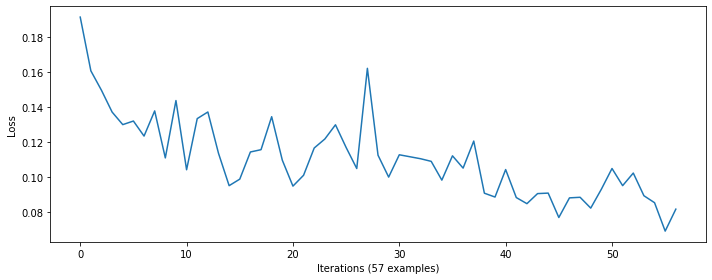

In [84]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(train_loss)
ax.set_ylabel('Loss')
ax.set_xlabel(f'Iterations ({len(train_loss)} examples)')
fig.tight_layout()
plt.show()

In [85]:
model = model.eval()
test_data = torch.utils.data.DataLoader(project_data_converted['train'], batch_size=4)

In [86]:
confusion = torch.zeros(num_labels, num_labels)
found = 0
missed = 0
wrong = 0

for i, batch in enumerate(tqdmn(test_data)):
    with torch.no_grad():
        batch = { k: v.to(device) for k, v in batch.items() }
        outputs = model(**batch)
            
    s_lengths = batch['attention_mask'].sum(dim=1)
    for idx, length in enumerate(s_lengths):
        true_values = batch['labels'][idx][:length]
        pred_values = torch.argmax(outputs[1], dim=2)[idx][:length]
        for true, pred in zip(true_values, pred_values):
            confusion[true.item()][pred.item()] += 1
            if true.item() > 0:
                if pred.item() > 0:
                    found += 1
                else: 
                    missed += 1
            elif pred.item() > 0:
                wrong += 1

In [92]:
if found + wrong == 0:
    precision = 0.0
else:
    precision = found / (found + wrong)
recall = found / (found + missed)

print(f"precision: {100*precision:0.3}%; recall: {100*recall:0.3}%")

precision: 76.8%; recall: 39.1%


In [93]:
for i in range(num_labels):
    confusion[i] = confusion[i] / confusion[i].sum()

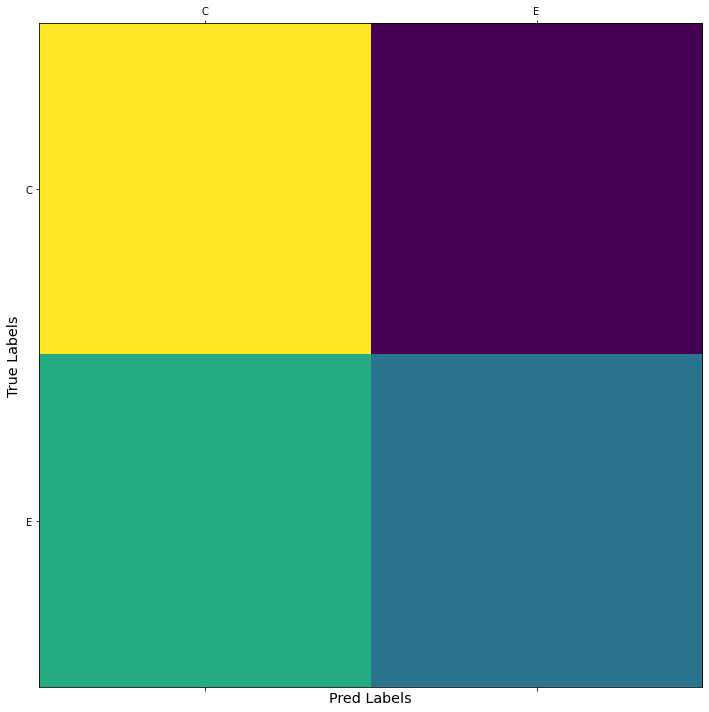

In [94]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.matshow(confusion.numpy())

labels = list(label2id.keys())
ids = np.arange(len(labels))

ax.set_ylabel('True Labels', fontsize='x-large')
ax.set_xlabel('Pred Labels', fontsize='x-large')

ax.set_xticks(ids)
ax.set_xticklabels(labels)

ax.set_yticks(ids)
ax.set_yticklabels(labels)

fig.tight_layout()
plt.show()

In [95]:
confusion.numpy()

array([[0.9766508 , 0.02334921],
       [0.60879076, 0.39120921]], dtype=float32)